In [33]:
% load_ext autoreload
% autoreload 2
% matplotlibinline

import os
from functools import reduce

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import sys
sys.path.append('..')
from src.evaluation.evaluator import Evaluator
from src.datasets import SyntheticDataGenerator, MultivariateAnomalyFunction
import main

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


TODO:
- XOR (Anomaly -> gleichzeitig)
- Ableitung (Geschwindigkeit vs Beschleunigung)
- Invers

## Plot missing results

In [116]:
datasets = [SyntheticDataGenerator.get(f'extreme_1_missing', 42, missing) for missing in np.linspace(0, 0.9, 5)]
detectors = main.get_detectors()[:1] + main.get_detectors()[1:]

In [ ]:
seeds = np.random.randint(low=0, high=2 ** 32 - 1, size=30, dtype="uint32")
print_order = ["dataset", "algorithm", "accuracy", "precision", "recall", "F1-score", "F0.1-score", "auroc"]
rename_columns = [col for col in print_order if col not in ['dataset', 'algorithm']]
results = pd.DataFrame()

for i, seed in enumerate(seeds):
    evaluator = Evaluator(datasets if datasets else get_pipeline_datasets(seed), detectors, seed=seed, output_dir='data')
    evaluator.evaluate()
    result = evaluator.benchmarks()
    evaluator.benchmark_results = result
    evaluator.export_results(f'missing-run-{i}-{seed}')
    del evaluator  # Save memory
    results = results.append(result, ignore_index=True)

In [ ]:
avg_results = results.groupby(["dataset", "algorithm"], as_index=False).mean()
std_results = results.groupby(["dataset", "algorithm"]).std(ddof=0)

evaluator = Evaluator(datasets if datasets else get_pipeline_datasets(seed), detectors, seed=42, output_dir='data')
evaluator.benchmark_results = avg_results

In [ ]:
print(f'{"-"*20} Average {"-"*20}')
print(avg_results)
print(f'{"-"*22} Std {"-"*22}')
print(std_results)

In [ ]:
path = evaluator.export_results('missing-final')

In [ ]:
evaluator2 = Evaluator(datasets, detectors, output_dir='data')
evaluator2.import_results(path[5:-4])

In [ ]:
fig = evaluator2.plot_experiment_comparison('Missing')

### Read results from pickle

In [19]:
pickle_dirs = ['data/exe2']
datasets = [SyntheticDataGenerator.get(f'extreme_1_missing', 42, missing) for missing in np.linspace(0, 0.9, 5)]
detectors = main.get_detectors()
evaluators = []
for dir_ in pickle_dirs:
    for path in os.listdir(os.path.join(dir_, 'evaluators')):
        ev = Evaluator(datasets, detectors, output_dir=dir_)
        ev.import_results(path[:-4])
        evaluators.append(ev)
results = [ev.benchmark_results for ev in evaluators]

2018-07-12 11:11:55 [INFO] src.evaluation.evaluator: Read evaluator results at /home/thomas/work/notebooks/data/exe2/evaluators/missing-run-6-2436925548-2018-07-11-165158.pkl
2018-07-12 11:11:55 [INFO] src.evaluation.evaluator: Read evaluator results at /home/thomas/work/notebooks/data/exe2/evaluators/missing-run-19-3916836597-2018-07-11-223357.pkl
2018-07-12 11:11:55 [INFO] src.evaluation.evaluator: Read evaluator results at /home/thomas/work/notebooks/data/exe2/evaluators/missing-run-9-840763924-2018-07-11-180139.pkl
2018-07-12 11:11:55 [INFO] src.evaluation.evaluator: Read evaluator results at /home/thomas/work/notebooks/data/exe2/evaluators/missing-run-8-3419840286-2018-07-11-173809.pkl
2018-07-12 11:11:55 [INFO] src.evaluation.evaluator: Read evaluator results at /home/thomas/work/notebooks/data/exe2/evaluators/missing-run-14-2096707148-2018-07-11-200851.pkl
2018-07-12 11:11:55 [INFO] src.evaluation.evaluator: Read evaluator results at /home/thomas/work/notebooks/data/exe2/evaluat

In [63]:
aurocs = [x[['algorithm', 'dataset', 'auroc']] for x in results]
aurocs_df = pd.concat(aurocs, axis=0, ignore_index=True)
auroc_groups = aurocs_df.groupby(['algorithm', 'dataset'])
aurocs_mean = auroc_groups.mean().reset_index()
aurocs_std= auroc_groups.std().reset_index()

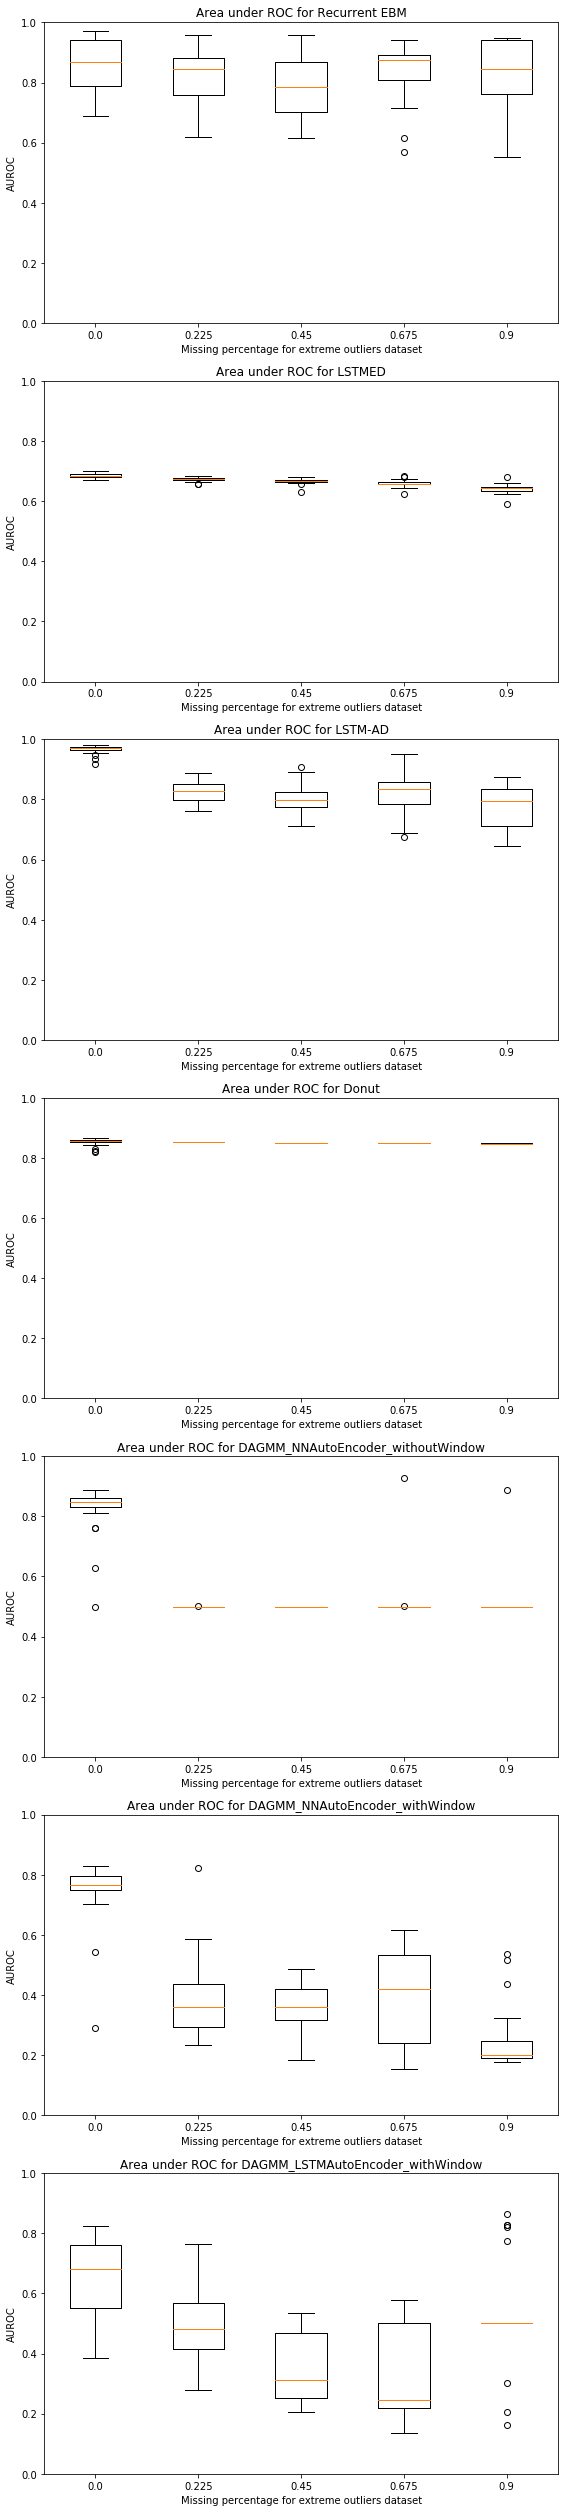

In [113]:
det_names = [str(x) for x in detectors[:]]
ds_names = [str(x) for x in datasets]
fig, axes = plt.subplots(len(det_names), figsize = (8, 5*len(det_names)))
for ax, det in zip(axes.flat, det_names):
    values = aurocs_df[aurocs_df['algorithm'] == det].drop(columns='algorithm')
    ds_groups = values.groupby('dataset')
    ax.boxplot([ds_groups.get_group(x)['auroc'].values for x in ds_names])
    ax.set_title(f'Area under ROC for {det}')
    ax.set_xticklabels([Evaluator.get_key_and_value(x)[1] for x in ds_names])
    ax.set_xlabel('Missing percentage for extreme outliers dataset')
    ax.set_ylabel('AUROC')
    ax.set_ylim((0, 1))
fig.tight_layout()
fig.savefig('boxplots-auroc-datasets.pdf')

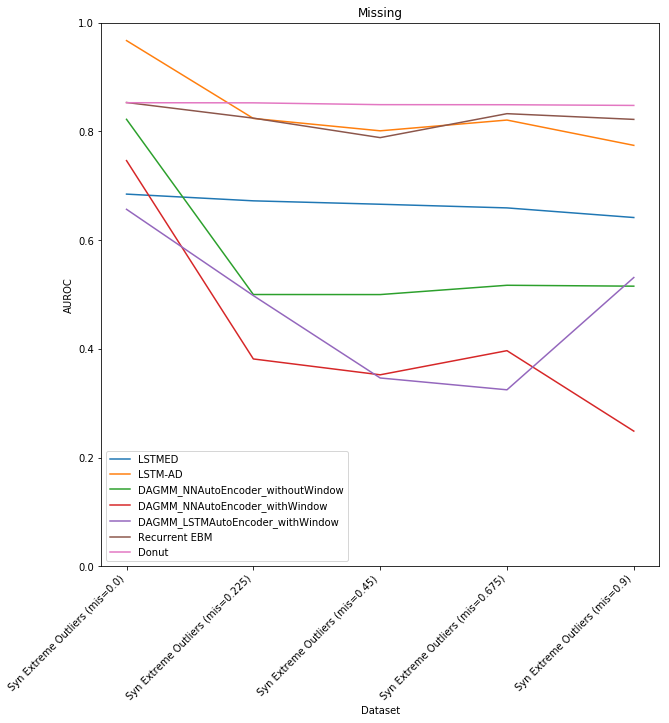

In [114]:
mean_ev = Evaluator(datasets, detectors, output_dir='data')
mean_ev.set_benchmark_results(aurocs_mean)
fig = mean_ev.plot_experiment_comparison('Missing')
fig.savefig('missing-auroc.pdf')

### Evaluate DAGMM

In [159]:
datasets2 = [SyntheticDataGenerator.get(f'variance_1_missing', 100, 0)]
detectors2 = main.get_detectors()[3:4]
ev2 = Evaluator(datasets2, detectors2, output_dir=dir_)
ev2.evaluate()
result = ev2.benchmarks()
ev2.benchmark_results = result
# evaluator.export_results(f'missing-run-{i}-{seed}')

N/A% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

2018-07-12 16:59:39 [INFO] src.evaluation.evaluator: Training Donut on Syn Variance Outliers (mis=0) with seed 42


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from /tmp/tmpf0fxnkii/variables.dat-500
2018-07-12 16:59:56 [INFO] tensorflow: Restoring parameters from /tmp/tmpf0fxnkii/variables.dat-500


100%|██████████| 1/1 [00:16<00:00, 16.88s/it]
100% (1 of 1) |##########################| Elapsed Time: 0:00:19 Time:  0:00:19
100% (1 of 1) |##########################| Elapsed Time: 0:00:19 Time:  0:00:19


2018-07-12 16:59:59 [INFO] src.evaluation.evaluator: Plotting ROC curve for Donut on Syn Variance Outliers (mis=0)
2018-07-12 16:59:59 [INFO] src.evaluation.evaluator: Stored plot at data/exe2/figures/seed-42/roc_Syn Variance Outliers (mis=0)-1-1-2018-07-12-165959.pdf


[<Figure size 216x216 with 1 Axes>]

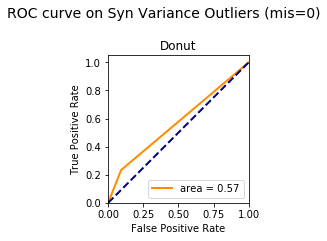

In [160]:
ev2.plot_roc_curves()

   F0.1-score  F1-score  accuracy algorithm     auroc  \
0    0.386339  0.291667  0.773333     Donut  0.570833   

                         dataset  precision    recall  
0  Syn Variance Outliers (mis=0)   0.388889  0.233333  
2018-07-12 17:00:00 [INFO] src.evaluation.evaluator: Stored plot at data/exe2/figures/seed-42/scores_Syn Variance Outliers (mis=0)-1-1-2018-07-12-165959.pdf


[<Figure size 1080x1080 with 5 Axes>]

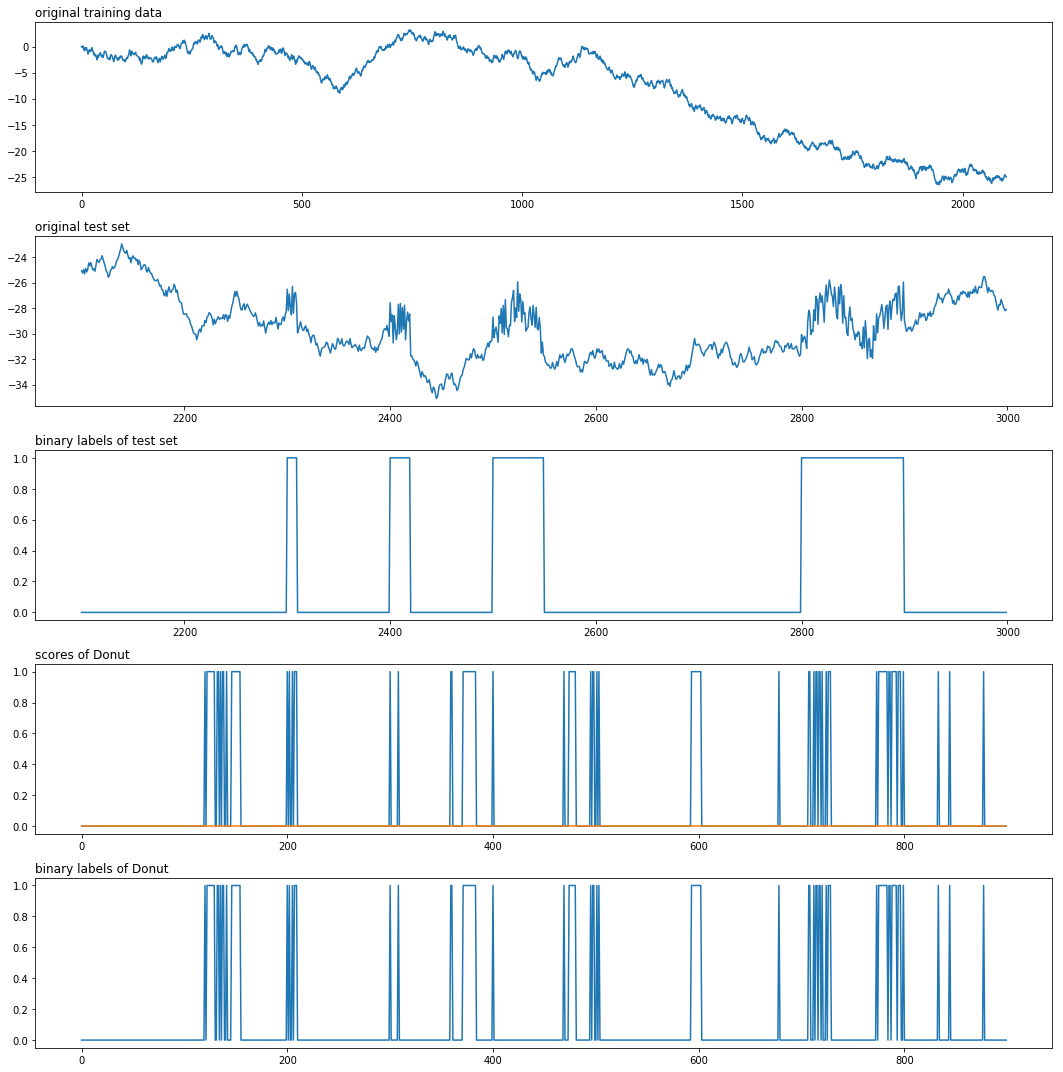

In [161]:
print(ev2.benchmark_results)
ev2.plot_scores(9)